In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, t
from bdpy.dataform import Features, save_array, load_array
from tqdm import tqdm

In [2]:
rois = ['ROI_V1', 'ROI_V2', 'ROI_V3', 'ROI_hV4', 'ROI_HVC']
layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']

In [3]:
unet_pc_dir = '/home/shunosuga/data/decoded_features/deeprecon_unet/prediction_accuracy'
caffe_pc_dir = '/home/shunosuga/data/decoded_features/deeprecon_caffenet/prediction_accuracy'

In [7]:
# AM
subject = 'AM'
AM_caffe_pc = []

for i in range(len(layers)):
    list = []
    layer = layers[i]

    for j in range(len(rois)):
        roi = rois[j]
        pc_ = load_array(os.path.join(caffe_pc_dir, 'caffenet', layer, subject, roi, 'profile_correlation.mat'), key='profile_correlation')
        pc_ = pc_.flatten()
        #pc_ = np.random.choice(pc_, 1000)
        list.append(pc_)

    list = np.array(list)
        
    AM_caffe_pc.append(list)

AM_unet_pc = []

for i in range(len(layers)):
    list = []
    layer = layers[i]

    for j in range(len(rois)):
        roi = rois[j]
        pc_ = load_array(os.path.join(unet_pc_dir, 'caffenet', layer, subject, roi, 'profile_correlation.mat'), key='profile_correlation')
        pc_ = pc_.flatten()
        #pc_ = np.random.choice(pc_, 1000)
        list.append(pc_)

    list = np.array(list)
        
    AM_unet_pc.append(list)


In [8]:
# ES
subject = 'ES'
ES_caffe_pc = []

for i in range(len(layers)):
    list = []
    layer = layers[i]

    for j in range(len(rois)):
        roi = rois[j]
        pc_ = load_array(os.path.join(caffe_pc_dir, 'caffenet', layer, subject, roi, 'profile_correlation.mat'), key='profile_correlation')
        pc_ = pc_.flatten()
        #pc_ = np.random.choice(pc_, 1000)
        list.append(pc_)

    list = np.array(list)
        
    ES_caffe_pc.append(list)

ES_unet_pc = []

for i in range(len(layers)):
    list = []
    layer = layers[i]

    for j in range(len(rois)):
        roi = rois[j]
        pc_ = load_array(os.path.join(unet_pc_dir, 'caffenet', layer, subject, roi, 'profile_correlation.mat'), key='profile_correlation')
        pc_ = pc_.flatten()
        #pc_ = np.random.choice(pc_, 1000)
        list.append(pc_)

    list = np.array(list)
        
    ES_unet_pc.append(list)


In [9]:
# TH
subject = 'TH'
TH_caffe_pc = []

for i in range(len(layers)):
    list = []
    layer = layers[i]

    for j in range(len(rois)):
        roi = rois[j]
        pc_ = load_array(os.path.join(caffe_pc_dir, 'caffenet', layer, subject, roi, 'profile_correlation.mat'), key='profile_correlation')
        pc_ = pc_.flatten()
        #pc_ = np.random.choice(pc_, 1000)
        list.append(pc_)

    list = np.array(list)
        
    TH_caffe_pc.append(list)

TH_unet_pc = []

for i in range(len(layers)):
    list = []
    layer = layers[i]

    for j in range(len(rois)):
        roi = rois[j]
        pc_ = load_array(os.path.join(unet_pc_dir, 'u_net', layer, subject, roi, 'profile_correlation.mat'), key='profile_correlation')
        pc_ = pc_.flatten()
        #pc_ = np.random.choice(pc_, 1000)
        list.append(pc_)

    list = np.array(list)
        
    TH_unet_pc.append(list)

In [23]:
caffe_pc = []

for i in range(8):
    pc_ = np.block([AM_caffe_pc[i], ES_caffe_pc[i], TH_caffe_pc[i]])
    caffe_pc.append(pc_)

unet_pc = []

for i in range(8):
    pc_ = np.block([AM_unet_pc[i], ES_unet_pc[i], TH_unet_pc[i]])
    unet_pc.append(pc_)

In [27]:
def compute_bhscore(predacc_list, pval=0.05, return_top_rois=False):
    """Compute a BH score of a given DNN.
    Parameters
    ----------
    predacc_list : list of arrays
        List of prediction accuracies for a DNN. Each array contains
        prediction accuracies of individual units in a layer, formed as an
         array of ROIs x units.
    pval : float, default = 0.05
        P-value threshold in unit selection.
    return_top_rois : bool, default = False
        Returns top ROIs if True.
    Returns
    -------
    bhscore : float
    top_rois: list of arrays
    """

    top_rois = []
    for predacc in predacc_list:
    
        # for each CNN units, search roi which has the highest prediction accuracy
        pred_max = np.max(predacc, axis=0)
        pred_max_ind = np.argmax(predacc, axis=0)

        # compute p value of the highest decoding accuracy
        
        tmp = np.sqrt((50 - 2) * (1 - pred_max ** 2))
        tmp = pred_max * tmp
        pval = 2 * (1 - t.cdf(tmp, df=50 - 2))

        # keep unit with p value < threshold and acc > 0
        threshold = pval < 0.05
        plus_unit = pred_max > 0
        select_unit_ind = np.logical_and(threshold, plus_unit)
        pred_max_ind = pred_max_ind[select_unit_ind]

        top_rois.append(pred_max_ind)

    # get layer numbers of each unit. concatenate best ROIs for all layers
    layer_numbers = []
    best_roi_flatten = []
    for i_br, br in enumerate(top_rois):
        layer_numbers.extend(np.repeat(i_br + 1, len(br)))
        best_roi_flatten.extend(br)

    # compute Spearman's rank correlation
    bhscore, _ = spearmanr(layer_numbers, best_roi_flatten)

    if return_top_rois:
        return bhscore, top_rois
    else:
        return bhscore


def compute_bhscore_layerselect(predacc_list, pval=0.05, n_layers=5,
                                n_repeat=100, return_top_rois=False):
    """Compute a BH score of a given DNN, random layer selection version.
    Parameters
    ----------
    predacc_list : list of arrays
        List of prediction accuracies for a DNN. Each array contains
        prediction accuracies of individual units in a layer, formed as an
         array of ROIs x units.
    pval : float, default = 0.05
        P-value threshold in unit selection.
    n_layers : int, default = 5
        The number of layers used to compute the BH score. Note that the first
        and last layers are always included in the computation. Thus,
        (n_layers - 2) layers are randomly selected from the representative
        layers except the first and last ones.
    n_repeat : int, default = 100
        The number of random layer selection.
    return_top_rois : bool, default = False
        Returns top ROIs if True.
    Returns
    -------
    bhscore_list : arary of float
    top_rois_list : list of list of arrays
    """

    bhscore_list = np.zeros(n_repeat)
    top_rois_list = []
    for i_s in range(n_repeat):
        # sample layers
        sample_index = np.random.choice(np.arange(1, len(predacc_list)-1), size=n_layers - 2, replace=False)
        sample_index = np.sort(sample_index)
        predacc_list_sampled = [predacc_list[0]] + [predacc_list[i] for i in sample_index] + [predacc_list[-1]]

        bhscore, top_rois = compute_bhscore(predacc_list_sampled, pval, return_top_rois=True)
        bhscore_list[i_s] = bhscore
        top_rois_list.append(top_rois)

    if return_top_rois:
        return bhscore_list, top_rois_list
    else:
        return bhscore_list


In [40]:
caffe_bh = []
unet_bh = []

for i in tqdm(range(10000)):
    caffe_pc_sample = []
    unet_pc_sample = []

    for j in range(8):
        caffe_pc_ = caffe_pc[j]
        caffe_ind = np.random.choice(range(caffe_pc_.shape[1]), 1000)

        unet_pc_ = unet_pc[j]
        unet_ind = np.random.choice(range(unet_pc_.shape[1]), 1000)

        caffe_pc_sample.append(caffe_pc_[:, caffe_ind])
        unet_pc_sample.append(unet_pc_[:, unet_ind])


    caffe_bh.append(
        compute_bhscore_layerselect(caffe_pc_sample, n_repeat=1)[0]
    )

    unet_bh.append(
        compute_bhscore_layerselect(unet_pc_sample, n_repeat=1)[0]
    )



    

            

100%|██████████| 10000/10000 [1:23:00<00:00,  2.01it/s]


In [41]:
caffe_bh = np.array(caffe_bh)
unet_bh = np.array(unet_bh)

np.save('/home/shunosuga/project/caffe_feature_decoding/bh_score/caffe_bh', caffe_bh)
np.save('/home/shunosuga/project/caffe_feature_decoding/bh_score/unet_bh', unet_bh)

In [42]:
print(np.mean(caffe_bh), np.mean(unet_bh))

0.44478546131928215 0.6329378375463144


In [3]:
caffe = np.load('/home/shunosuga/project/caffe_feature_decoding/bh_score/caffe_bh.npy')
unet = np.load('/home/shunosuga/project/caffe_feature_decoding/bh_score/unet_bh.npy')

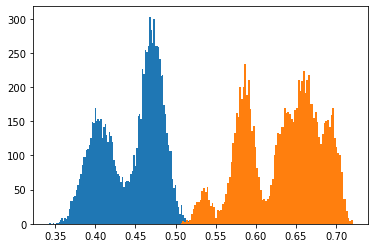

In [6]:


plt.hist(caffe, bins=100)
plt.hist(unet, bins=100)



In [31]:
caffe_bh = np.array(caffe_bh)
unet_bh = np.array(unet_bh)

print(caffe_bh.shape, unet_bh.shape)

print(np.mean(caffe_bh), np.mean(unet_bh))

(10000,) (10000,)
0.34337448410875293 0.4955970841417842


In [10]:
AM_caffe_maxind = []

for i in range(8):
    n = len(AM_caffe_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(5)

        for j in range(5):
            roi_wise[j] = AM_caffe_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    AM_caffe_maxind.append(max_indexes)

AM_unet_maxind = []

for i in range(8):
    n = len(AM_unet_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(5)

        for j in range(5):
            roi_wise[j] = AM_unet_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    AM_unet_maxind.append(max_indexes)

ES_caffe_maxind = []

for i in range(8):
    n = len(ES_caffe_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(5)

        for j in range(5):
            roi_wise[j] = ES_caffe_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    ES_caffe_maxind.append(max_indexes)

ES_unet_maxind = []

for i in range(8):
    n = len(ES_unet_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(5)

        for j in range(5):
            roi_wise[j] = ES_unet_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    ES_unet_maxind.append(max_indexes)

TH_caffe_maxind = []

for i in range(8):
    n = len(TH_caffe_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(5)

        for j in range(5):
            roi_wise[j] = TH_caffe_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    TH_caffe_maxind.append(max_indexes)

TH_unet_maxind = []

for i in range(8):
    n = len(TH_unet_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(5)

        for j in range(5):
            roi_wise[j] = TH_unet_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    TH_unet_maxind.append(max_indexes)

290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000
290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000
290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000
290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000
290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000
290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000


In [20]:
print(type(TH_unet_maxind[0]))

<class 'list'>


In [14]:
import random
from tqdm import tqdm
from scipy.stats import spearmanr

In [13]:
full_1000 = np.array([])

for i in range(8):
    gase = np.full(1000, i+1)
    full_1000 = np.concatenate([full_1000, gase])


In [16]:
layer_1000 = np.array([])

for i in range(8):
    target = AM_caffe_maxind[i]
    sample = random.sample(target, 1000)
    sample = np.array(sample)
    layer_1000 = np.concatenate([layer_1000, sample])

correlation, pvalue = spearmanr(full_1000, layer_1000)
print(correlation, pvalue)

layer_1000 = np.array([])

for i in range(8):
    target = AM_unet_maxind[i]
    sample = random.sample(target, 1000)
    sample = np.array(sample)
    layer_1000 = np.concatenate([layer_1000, sample])

correlation, pvalue = spearmanr(full_1000, layer_1000)
print(correlation, pvalue)

layer_1000 = np.array([])

for i in range(8):
    target = ES_caffe_maxind[i]
    sample = random.sample(target, 1000)
    sample = np.array(sample)
    layer_1000 = np.concatenate([layer_1000, sample])

correlation, pvalue = spearmanr(full_1000, layer_1000)
print(correlation, pvalue)

layer_1000 = np.array([])

for i in range(8):
    target = ES_unet_maxind[i]
    sample = random.sample(target, 1000)
    sample = np.array(sample)
    layer_1000 = np.concatenate([layer_1000, sample])

correlation, pvalue = spearmanr(full_1000, layer_1000)
print(correlation, pvalue)

layer_1000 = np.array([])

for i in range(8):
    target = TH_caffe_maxind[i]
    sample = random.sample(target, 1000)
    sample = np.array(sample)
    layer_1000 = np.concatenate([layer_1000, sample])

correlation, pvalue = spearmanr(full_1000, layer_1000)
print(correlation, pvalue)

layer_1000 = np.array([])

for i in range(8):
    target = TH_unet_maxind[i]
    sample = random.sample(target, 1000)
    sample = np.array(sample)
    layer_1000 = np.concatenate([layer_1000, sample])

correlation, pvalue = spearmanr(full_1000, layer_1000)
print(correlation, pvalue)


0.3330523297660403 1.715467768199967e-206
0.4616044033398315 0.0
0.32091200285800525 4.9039051452181586e-191
0.5259066234483177 0.0
0.37631762047514444 1.4772306946222952e-267
0.49842299178459754 0.0


In [21]:
caffe_maxind = []

for i in range(8):
    sub_ = AM_caffe_maxind[i] + ES_caffe_maxind[i] + TH_caffe_maxind[i]
    caffe_maxind.append(sub_)

unet_maxind = []

for i in range(8):
    sub_ = AM_unet_maxind[i] + ES_unet_maxind[i] + TH_unet_maxind[i]
    unet_maxind.append(sub_)

In [25]:
layer_1000 = np.array([])

for i in range(8):
    target = caffe_maxind[i]
    sample = random.sample(target, 1000)
    sample = np.array(sample)
    layer_1000 = np.concatenate([layer_1000, sample])

correlation, pvalue = spearmanr(full_1000, layer_1000)
print(correlation, pvalue)

layer_1000 = np.array([])

for i in range(8):
    target = unet_maxind[i]
    sample = random.sample(target, 1000)
    sample = np.array(sample)
    layer_1000 = np.concatenate([layer_1000, sample])

correlation, pvalue = spearmanr(full_1000, layer_1000)
print(correlation, pvalue)

0.3556890298234979 3.021106238555229e-237
0.5044632519481999 0.0


In [26]:
caffe_corrs = []

for j in tqdm(range(10000)):
    layer_1000 = np.array([])

    for i in range(8):
        target = caffe_maxind[i]
        sample = random.sample(target, 1000)
        sample = np.array(sample)
        layer_1000 = np.concatenate([layer_1000, sample])

    correlation, pvalue = spearmanr(full_1000, layer_1000)
    caffe_corrs.append(correlation)

print(np.mean(np.array(caffe_corrs)))

unet_corrs = []

for j in tqdm(range(10000)):
    layer_1000 = np.array([])

    for i in range(8):
        target = unet_maxind[i]
        sample = random.sample(target, 1000)
        sample = np.array(sample)
        layer_1000 = np.concatenate([layer_1000, sample])

    correlation, pvalue = spearmanr(full_1000, layer_1000)
    unet_corrs.append(correlation)

print(np.mean(np.array(unet_corrs)))

  0%|          | 13/10000 [00:00<01:21, 122.13it/s]

0.3527864512660049


100%|██████████| 10000/10000 [01:13<00:00, 135.88it/s]

0.4956946516650117


In [27]:
caffe_prop = []

for i in range(8):
    vel = []

    target = caffe_maxind[i]

    for j in range(5):
        ind = j + 1
        tel = 0

        for tar in target:
            if tar == ind:
                tel += 1
        
        vel.append(tel)

    print(vel)
    caffe_prop.append(vel)

unet_prop = []

for i in range(8):
    vel = []

    target = unet_maxind[i]

    for j in range(5):
        ind = j + 1
        tel = 0

        for tar in target:
            if tar == ind:
                tel += 1
        
        vel.append(tel)

    print(vel)
    unet_prop.append(vel)

[169583, 141729, 152929, 210493, 196466]
[144158, 121041, 122791, 106918, 64964]
[42476, 45471, 51292, 35048, 20401]
[42561, 46563, 52499, 31706, 21359]
[24133, 28204, 34294, 25181, 17980]
[629, 921, 3097, 3679, 3962]
[454, 784, 2454, 3679, 4917]
[40, 78, 403, 944, 1535]
[171849, 172332, 203309, 201347, 122363]
[187375, 117229, 94843, 97786, 62639]
[26912, 35294, 57783, 42950, 31749]
[33409, 33117, 48235, 47467, 32460]
[24833, 24303, 29192, 25404, 26060]
[634, 1681, 2945, 2495, 4533]
[551, 846, 1194, 1874, 7823]
[5, 7, 3, 37, 2948]


In [28]:
caffe_prop = np.array(caffe_prop)
unet_prop = np.array(unet_prop)

In [32]:
caffe_prop_ = []

for i in range(8):
    target = caffe_prop[i]
    sum_ = np.sum(target)

    caffe_prop_.append(target / sum_)

unet_prop_ = []

for i in range(8):
    target = unet_prop[i]
    sum_ = np.sum(target)

    unet_prop_.append(target / sum_)

caffe_prop_ = np.array(caffe_prop_)
unet_prop_ = np.array(unet_prop_)
    

In [33]:
print(caffe_prop_)
print(unet_prop_)

[[0.1946545  0.16268251 0.17553834 0.24161272 0.22551194]
 [0.25748385 0.21619406 0.21931977 0.19096865 0.11603366]
 [0.21817472 0.23355831 0.26345743 0.18002137 0.10478817]
 [0.21861132 0.23916728 0.26965709 0.16285544 0.10970887]
 [0.18593596 0.21730153 0.26422276 0.19401042 0.13852934]
 [0.05118815 0.07495117 0.25203451 0.29939779 0.32242839]
 [0.03694661 0.06380208 0.19970703 0.29939779 0.40014648]
 [0.01333333 0.026      0.13433333 0.31466667 0.51166667]]
[[0.19725551 0.19780992 0.23336662 0.23111455 0.1404534 ]
 [0.33467471 0.20938536 0.16940122 0.17465778 0.11188093]
 [0.13823143 0.18128493 0.29679795 0.22060939 0.16307631]
 [0.17160277 0.17010293 0.24775538 0.24381061 0.1667283 ]
 [0.1913292  0.18724575 0.22491371 0.19572855 0.20078279]
 [0.05159505 0.13680013 0.23966471 0.20304362 0.36889648]
 [0.04484049 0.06884766 0.09716797 0.15250651 0.63663737]
 [0.00166667 0.00233333 0.001      0.01233333 0.98266667]]


In [9]:
AM_unet_pc_ = AM_unet_pc[:-1]

In [10]:
AM_unet_pc_.shape

(4, 8)

In [11]:
AM_unet_pc = AM_unet_pc[:-1]
AM_caffe_pc = AM_caffe_pc[:-1]
ES_unet_pc = ES_unet_pc[:-1]
ES_caffe_pc = ES_caffe_pc[:-1]
TH_unet_pc = TH_unet_pc[:-1]
TH_caffe_pc = TH_caffe_pc[:-1]

In [12]:
AM_caffe_maxind = []

for i in range(8):
    n = len(AM_caffe_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(4)

        for j in range(4):
            roi_wise[j] = AM_caffe_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    AM_caffe_maxind.append(max_indexes)

AM_unet_maxind = []

for i in range(8):
    n = len(AM_unet_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(4)

        for j in range(4):
            roi_wise[j] = AM_unet_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    AM_unet_maxind.append(max_indexes)

ES_caffe_maxind = []

for i in range(8):
    n = len(ES_caffe_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(4)

        for j in range(4):
            roi_wise[j] = ES_caffe_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    ES_caffe_maxind.append(max_indexes)

ES_unet_maxind = []

for i in range(8):
    n = len(ES_unet_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(4)

        for j in range(4):
            roi_wise[j] = ES_unet_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    ES_unet_maxind.append(max_indexes)

TH_caffe_maxind = []

for i in range(8):
    n = len(TH_caffe_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(4)

        for j in range(4):
            roi_wise[j] = TH_caffe_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    TH_caffe_maxind.append(max_indexes)

TH_unet_maxind = []

for i in range(8):
    n = len(TH_unet_pc[0][i]) # n : ユニットの数
    print(n)
    max_indexes = []

    for k in range(n):
        roi_wise = np.zeros(4)

        for j in range(4):
            roi_wise[j] = TH_unet_pc[j][i][k]

        max_ind = np.argmax(roi_wise) + 1
        max_indexes.append(max_ind)

    print(len(max_indexes))

    TH_unet_maxind.append(max_indexes)

290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000
290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000
290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000
290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000
290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000
290400
290400
186624
186624
64896
64896
64896
64896
43264
43264
4096
4096
4096
4096
1000
1000


In [13]:
caffe_maxind = []

for i in range(8):
    sub_ = AM_caffe_maxind[i] + ES_caffe_maxind[i] + TH_caffe_maxind[i]
    caffe_maxind.append(sub_)

unet_maxind = []

for i in range(8):
    sub_ = AM_unet_maxind[i] + ES_unet_maxind[i] + TH_unet_maxind[i]
    unet_maxind.append(sub_)

In [14]:
caffe_prop = []

for i in range(8):
    vel = []

    target = caffe_maxind[i]

    for j in range(4):
        ind = j + 1
        tel = 0

        for tar in target:
            if tar == ind:
                tel += 1
        
        vel.append(tel)

    print(vel)
    caffe_prop.append(vel)

unet_prop = []

for i in range(8):
    vel = []

    target = unet_maxind[i]

    for j in range(4):
        ind = j + 1
        tel = 0

        for tar in target:
            if tar == ind:
                tel += 1
        
        vel.append(tel)

    print(vel)
    unet_prop.append(vel)

[209173, 174784, 193965, 293278]
[155649, 131841, 138442, 133940]
[45117, 48661, 57345, 43565]
[45335, 49964, 59065, 40324]
[26158, 30886, 39746, 33002]
[791, 1155, 4357, 5985]
[610, 1102, 3829, 6747]
[56, 126, 819, 1999]
[196501, 193090, 228921, 252688]
[201255, 127517, 107143, 123957]
[31240, 41287, 65638, 56523]
[37236, 38854, 54947, 63651]
[28315, 29231, 34874, 37372]
[725, 2132, 5849, 3582]
[734, 1733, 3013, 6808]
[9, 974, 64, 1953]


In [15]:
caffe_prop_ = []

for i in range(8):
    target = caffe_prop[i]
    sum_ = np.sum(target)

    caffe_prop_.append(target / sum_)

unet_prop_ = []

for i in range(8):
    target = unet_prop[i]
    sum_ = np.sum(target)

    unet_prop_.append(target / sum_)

caffe_prop_ = np.array(caffe_prop_)
unet_prop_ = np.array(unet_prop_)
    

In [16]:
print(caffe_prop_)
print(unet_prop_)

[[0.24009757 0.20062443 0.22264118 0.33663682]
 [0.27800819 0.23548418 0.24727438 0.23923325]
 [0.23174001 0.2499435  0.2945482  0.22376829]
 [0.23285976 0.25663626 0.30338285 0.20712114]
 [0.20153785 0.23796536 0.30622843 0.25426837]
 [0.06437174 0.09399414 0.35457357 0.48706055]
 [0.04964193 0.08968099 0.31160482 0.54907227]
 [0.01866667 0.042      0.273      0.66633333]]
[[0.22555211 0.22163682 0.26276515 0.29004591]
 [0.35946609 0.22776099 0.19137053 0.22140239]
 [0.16046187 0.21206751 0.33714456 0.29032606]
 [0.19125986 0.1995706  0.28223106 0.32693849]
 [0.21815674 0.22521419 0.26869144 0.28793762]
 [0.05900065 0.1735026  0.47599284 0.29150391]
 [0.05973307 0.1410319  0.24519857 0.55403646]
 [0.003      0.32466667 0.02133333 0.651     ]]
